In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import src.Fluid_CP as FCP
import src.Compressormodel_SP as CSP
from scipy.integrate import odeint
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint

In [4]:
# Constants and parameters (as you have)
tc_s = 12*60          # total cooking time seconds
tb_s = 5*60          # pasta added after 5 min
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta
Q_hp_W = 3984.26 # W

V_water = (47-0.4)*(27-0.4)*(20-0.2)/1e6  # m3
m_water = V_water * 1000                   # kg
m_pasta = 2                              # kg

T_env = 20
T_water_0 = 85
T_pasta_0 = 7

dt = 1  # 1 second timestep
time_steps = int(tc_s/dt) + 1
t = np.linspace(0, tc_s, time_steps)


T_WP_on = 85 #°C
T_WP_off = 93 #°C
rho_water=997. #kg/m3
WP = 1
time = 0

In [5]:
def calc_WP(T,T_WP_on,T_WP_off,op_times):
    global WP,time
    if WP==0 and T>T_WP_on:
        Q_WP=0. #kW WP off
        WP=0
        #time=0
    if WP==0 and T<=T_WP_on:
        Q_WP=4000 #kW WP switched on
        WP=1 #1=WP on
        time+=1
    if WP==1 and T<=T_WP_off:
        Q_WP=4000 #kW WP on
        time+=1
    if WP==1 and T>T_WP_off:
        Q_WP=0. #kW WP switched off
        WP=0
        op_times.append(time)
        time=0
    return Q_WP

### Keeping track of the temperatures

In [6]:
def temp_store_only_water(T_water,t,Q_WP,m_store,c_water):
    dT_waterdt = (Q_WP - (T_water - T_env)/R_env) / (m_store * c_water)
    return dT_waterdt


def temp_store_with_pasta(T, t, Q_WP, m_store, m_pasta, c_water):
    T_water, T_pasta = T  # unpack states
    dT_waterdt = (Q_WP - (T_water - T_env)/R_env - (T_water - T_pasta)/R_pasta) / (m_store * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

### Create binary list for when pasta is in water

In [7]:
def make_pasta_list(t):
    pasta_counter = 7*60 #seconds with pasta
    no_pasta_counter = 5*60  #seconds without pasta
    pasta_presence = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif no_pasta_counter > 0:
            pasta_presence[i] = 0
            no_pasta_counter -= 1
        else:
            pasta_counter = 7*60-1
            no_pasta_counter = 5*60
            pasta_presence[i] = 1
            
        
    return pasta_presence



### Operation

In [8]:
def T_store_and_pasta(T_WP_on,T_WP_off,V_store,n,op_times):
    
    #initial storage temperature
    T0_water = T_WP_on #fully charged
    T0_pasta = 7
    # time points
    t = np.linspace(0,n,n)
    # store storage and pasta temperature
    T_water=np.zeros(n)
    T_pasta = np.full(n, 7)
    # save initial storage and pasta temperature
    T_water[0] = T0_water
    T_pasta[0] = 7
    # mass water in storage
    m_store=V_store/1e3*rho_water #kg
    c_water = 4.18*1000 #J/kgK
    m_pasta = 2 #kg
    c_pasta = 3.5*1000 #J/kgK
    
    # heat pump
    Q_WPs=np.zeros(n) #store power of heat pump
    Q_WPs[0]=0 #kW power of heat pump at t=0 is 0 kW
    
    #make binary list for when pasta is in water -> first 7min in water
    binary_pasta = make_pasta_list(t)

    # solve differential equation for the storage temperature
    for i in range(1,n):
        if binary_pasta[i] == 0:
            # span for next time step
            tspan = [t[i-1],t[i]]
            # solve for next step
            z = odeint(temp_store_only_water,T0_water,tspan,args=(Q_WPs[i-1],m_store,c_water))
            #heat pump power for netxt time step
            Q_WPs[i]=calc_WP(z[1],T_WP_on,T_WP_off,op_times)
            # store storage and pasta temperature
            T_water[i] = z[1]
            T_pasta[i] = 7
            # next initial condition
            T0_water = z[1]
            #reset temperature for T_pasta
            T0_pasta = 7 #°C
            
        else:
            tspan = np.linspace(t[i-1], t[i], num=10)  # finer steps between two main time steps
            T_function = [T0_water, T0_pasta]

            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i-1], m_store, m_pasta, c_water, c_pasta))
            
            # update for next iteration
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]
            print(T0_water)
            print(T0_pasta)

            # calculate heat pump power for next step using last water temp only
            Q_WPs[i] = calc_WP(T0_water, T_WP_on, T_WP_off, op_times)

            T_water[i] = T0_water
            T_pasta[i] = T0_pasta


            
            
    # plot results    
    #fig, ax1 = plt.subplots()
    #ax2 = ax1.twinx()
    #ax1.plot(t,T,'r--',label='T_store')
    #ax2.plot(t,Q_WPs,'g:',label='Q_WP')
    #ax1.set_xlabel('time in seconds')
    #ax1.set_ylabel('T_store in °C', color='r')
    #ax2.set_ylabel('Q_WP in kW', color='g')
    #plt.show()
    
    # plot results    
    fig, (ax1,ax2) = plt.subplots(2,sharex=True)

    ax1.plot(t,T_water,'r--',label='T_store')
    ax2.plot(t,Q_WPs,'g:',label='Q_WP')
    ax2.set_xlabel('time in seconds')
    ax1.set_ylabel('T_store in °C', color='r')
    ax2.set_ylabel('Q_WP in kW', color='g')
    plt.show()
    
    
    return t,Q_WPs,T_water,T_pasta

In [ ]:
V_store = (47-0.4) * (27-0.4) * (20-0.2) /1000 #L
n = 12*60*60 #sec
op_times=list() #list for operating times

#calculation temperature profile and heat pump operating times
t1,Q_WPs1,T_water,T_pasta=T_store_and_pasta(T_WP_on,T_WP_off,V_store,n,op_times)

#if heat pump is running at the end of the time range, the running time is added to the list
if time!=0:
    op_times.append(time)
print("Min operating time=",round(min(op_times)/60.,2),"minutes")
print("Max operating time=",round(max(op_times)/60.,2),"minutes")
print("Number of times heat pump was switched on=",len(op_times))

TypeError: temp_store_with_pasta() takes 6 positional arguments but 7 were given

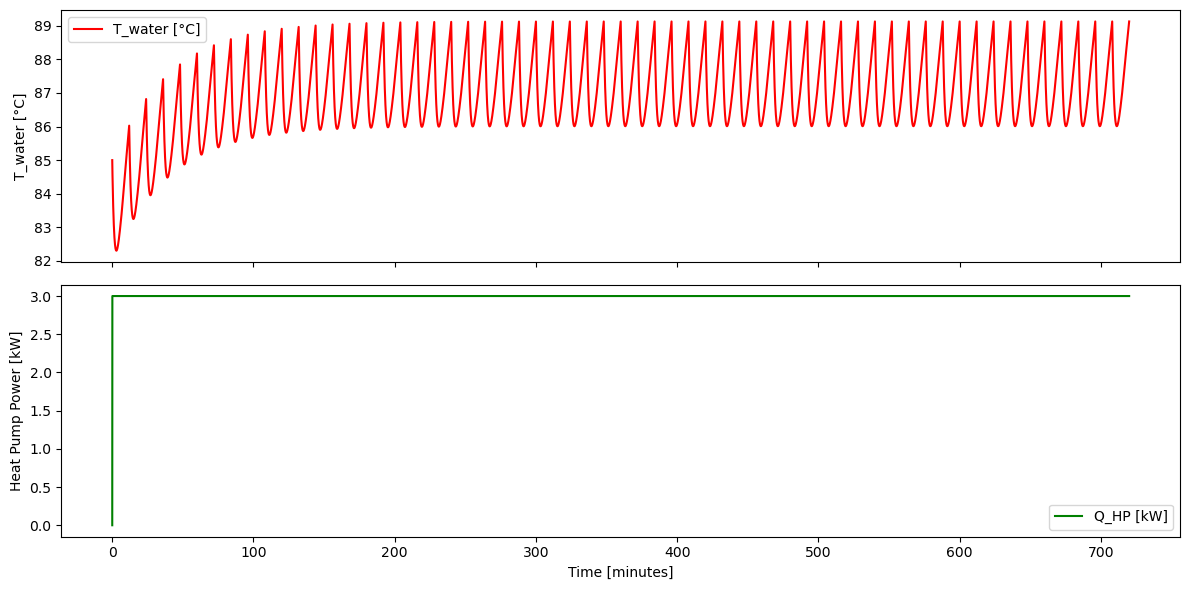

Min operating time = 0 minutes
Max operating time = 0 minutes
Number of heat pump on-cycles = 0


In [40]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- Global control variables ---
WP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta
Q_hp_W = 3000    # W

T_env = 20           # °C
T_pasta_0 = 7        # °C
T_WP_on = 85         # °C
T_WP_off = 93        # °C
rho_water = 997.     # kg/m3

# --- Dimensions of the water tank ---
V_store = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000  # L
m_store = V_store / 1e3 * rho_water  # kg

# --- Pasta batch schedule (7 min cook, 5 min break) ---
def make_pasta_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_presence

# --- Heat pump control logic ---
def calc_WP(T, T_on, T_off, op_times):
    global WP, time
    if T < T_on+1:
        if WP == 0:
            time = 0
        WP = 1
    elif T > T_off:
        if WP == 1:
            op_times.append(time)
        WP = 0

    if WP == 1:
        time += 1
        return Q_hp_W
    else:
        return 0

# --- ODE for water only ---
def temp_store_only_water(T_water, t, Q_WP, m_store, c_water):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_store * c_water)
    return dT_waterdt

# --- ODE for water + pasta ---
def temp_store_with_pasta(T, t, Q_WP, m_store, m_pasta, c_water, c_pasta):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_store * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

# --- Main simulation ---
def T_store_and_pasta(T_WP_on, T_WP_off, V_store, duration_s, op_times):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0)
    Q_WPs = np.zeros(duration_s)

    T0_water = T_WP_on
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    m_store = V_store / 1e3 * rho_water
    m_pasta = 2  # kg

    binary_pasta = make_pasta_list(t)

    global WP, time
    WP = 1
    time = 0

    for i in range(1, duration_s):
        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_store, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0
        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_store, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_WP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta

# --- Run simulation ---
duration_seconds = 12 * 60 * 60  # 12 hours
op_times = []
t, Q_WPs, T_water, T_pasta = T_store_and_pasta(T_WP_on, T_WP_off, V_store, duration_seconds, op_times)

# --- Plot results ---
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 6))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax2.legend()
plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)

print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)

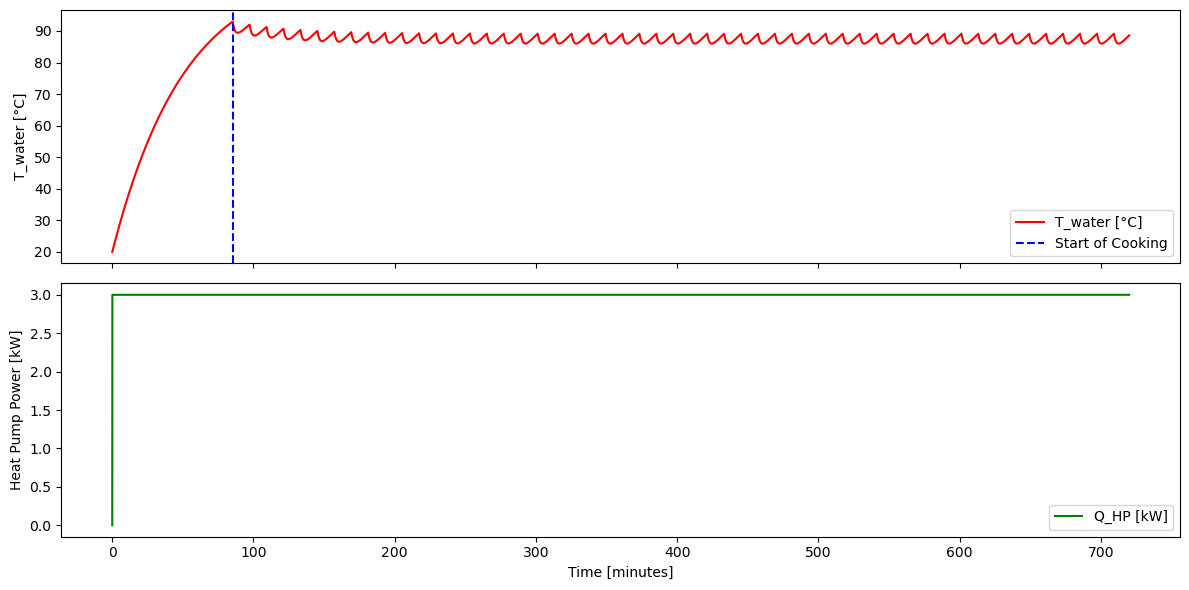

Time until cooking starts (heat-up) = 85.27 minutes
Min operating time = 0 minutes
Max operating time = 0 minutes
Number of heat pump on-cycles = 0


In [38]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- Global control variables ---
WP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta
Q_hp_W = 3000  # W

T_env = 20           # °C
T_pasta_0 = 7        # °C
T_WP_on = 85         # °C
T_WP_off = 93        # °C
rho_water = 997.     # kg/m3

# --- Dimensions of the water tank ---
V_store = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000  # L
m_store = V_store / 1e3 * rho_water  # kg

# --- Pasta batch schedule (7 min cook, 5 min break) ---
def make_pasta_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_presence

# --- Heat pump control logic ---
def calc_WP(T, T_on, T_off, op_times):
    global WP, time
    if T < T_on:
        if WP == 0:
            time = 0
        WP = 1
    elif T > T_off:
        if WP == 1:
            op_times.append(time)
        WP = 0

    if WP == 1:
        time += 1
        return Q_hp_W
    else:
        return 0

# --- ODE for water only ---
def temp_store_only_water(T_water, t, Q_WP, m_store, c_water):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_store * c_water)
    return dT_waterdt

# --- ODE for water + pasta ---
def temp_store_with_pasta(T, t, Q_WP, m_store, m_pasta, c_water, c_pasta):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_store * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

# --- Main simulation with morning heat-up ---
def T_store_and_pasta_with_heatup(T_WP_on, T_WP_off, V_store, duration_s, op_times):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0)
    Q_WPs = np.zeros(duration_s)

    T0_water = T_env  # Start at room temp
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    m_store = V_store / 1e3 * rho_water
    m_pasta = 2  # kg

    binary_pasta = np.zeros(duration_s)

    global WP, time
    WP = 1
    time = 0
    pasta_schedule_started = False
    pasta_schedule_start_index = None

    for i in range(1, duration_s):
        if not pasta_schedule_started and T0_water >= T_WP_off - 0.001: #start pasta cooking when we reach near the upper limit
            pasta_schedule_start_index = i
            binary_pasta[i:] = make_pasta_list(np.arange(duration_s - i))
            pasta_schedule_started = True

        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_store, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0
        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_store, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_WP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta, pasta_schedule_start_index

# --- Run simulation ---
duration_seconds = 12 * 60 * 60  # 12 hours
op_times = []
t, Q_WPs, T_water, T_pasta, start_index = T_store_and_pasta_with_heatup(
    T_WP_on, T_WP_off, V_store, duration_seconds, op_times)

# --- Plot results ---
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 6))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
if start_index:
    ax1.axvline(t[start_index] / 60, color='blue', linestyle='--', label='Start of Cooking')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax2.legend()
plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)
heatup_time_min = round(t[start_index] / 60, 2) if start_index else "N/A"

print("Time until cooking starts (heat-up) =", heatup_time_min, "minutes")
print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)

### rewrite so that COP is plotted over time with the empirical formula and an assumed formula for the inner cop

In [37]:
print(list(T_water))

[20.0, 20.0, 20.039101652782275, 20.078190565666496, 20.11726674280094, 20.156330188332532, 20.19538090590852, 20.234418898920122, 20.27344417152839, 20.31245672786747, 20.351456572090424, 20.390443708321474, 20.429418140708226, 20.46837987339037, 20.507328910502927, 20.54626525618112, 20.585188914562707, 20.624099889776023, 20.662998185960078, 20.701883807239845, 20.74075675774839, 20.779617041612518, 20.81846466295869, 20.857299625911917, 20.896121934598312, 20.93493159314044, 20.973728605660163, 21.012512976276394, 21.051284709108113, 21.090043808274196, 21.128790277890104, 21.167524122069718, 21.206245344927847, 21.244953950576587, 21.283649943126388, 21.32233332668719, 21.361004105366668, 21.39966228327274, 21.438307864509472, 21.476940853182477, 21.51556125339403, 21.554169069245503, 21.592764304837267, 21.631346964268054, 21.669917051635533, 21.708474571035772, 21.747019526563932, 21.785551922313143, 21.8240717623758, 21.862579050842804, 21.90107379180361, 21.939555989346594, 21